# Creating synthetic Titanic passenger data with SMOTE

Synthetic data may be useful to share when it is not possible to share original data, or to augment data for a class of interest for which we do not have sufficient data.

Here we use original Titanic passenger data to create new synthetic passenger data. We then train a logistic regression model on that synthetic data and test on real data that was not used to create the synthetic data.

## Description of SMOTE

SMOTE stands for Synthetic Minority Oversampling Technique [1]. SMOTE is most commonly used to create additional data to enhance modelling fitting, especially when one or more classes have low prevalence in the data set. Hence the description of oversampling.

SMOTE works by finding near-neighbor points in the original data, and creating new data points from interpolating between two near-neighbor points.

In this example, we remove the real data used to create the synthetic data, leaving only the synthetic data. This is the process you would go through if you were looking to use synthetic data INSTEAD OF real data. After generating synthetic data we remove any data points that, by chance, are identical to original real data points, and also remove 10% of points that are closest to the original data points. We measure ‘closeness’ by the Cartesian distance between standardised data values.

![](./images/smote.png)

*Demonstration of SMOTE method. (a) Data points with two features (shown on x and y axes) are represented. Points are colour-coded by class label. (b) A data point from a class is picked at random, shown by the black point, and then the closest neighbours of the same class are identified, as shown by yellow points. Here we show 3 closest neighbours, but the default in the SMOTE `Imbalanced-Learn` library is 6. One of those near-neighbour points is selected at random (shown by the dark brown point). A new data point, shown in red, is created at a random distance between the two selected data points.*

### Handling integer, binary, and categorical data

The standard SMOTE method generates floating point (non-integer) values between data points. There are alternative ways of handing integer, binary, and categorical data using the SMOTE method. Here the methods we use are:

* *Integer* values: Round the resulting synthetic data point value to the closest integer.

* *Binary*: Code the value as 0 or 1, and round the resulting synthetic data point value to the closest integer (0 or 1).

* *Categorical*: One-hot encode the categorical feature. Generate the synthetic data for each category value. Identify the category with the highest value and set to 1 while setting all others to 0.

### Implementation with IMBLEARN

Here use the implementation in the IMBLEARN IMBALANCED-LEARN [2] 

[1] Chawla, N.V., Bowyer, K.W., Hall, L.O., Kegelmeyer, W.P. “SMOTE: Synthetic minority over-sampling technique,” Journal of Artificial Intelligence Research, vol. 16, pp. 321-357, 2002.

[2] Lemaitre, G., Nogueira, F. and Aridas, C. (2016), Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning. arXiv:1609.06570 (https://pypi.org/project/imbalanced-learn/, `pip install imbalanced-learn`).


Many of the initial steps in this notebook will be familiar to you from the earlier Machine Learning sessions, and therefore there is not an extensive explanation of these sections.

First, we will fit a Logistic Regression model using the real Titanic data, just as we did before.  Then, we'll create some synthetic data from the Titanic data, and use that to fit a Logistic Regression model instead.  We'll compare performance on the two models - one using the real data, and one using synthetic data.

## Load packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.neighbors import NearestNeighbors

# Import package for SMOTE
import imblearn

# import SMOTE from imblearn so we can use it
from imblearn.over_sampling import SMOTE

# Turn warnings off to keep notebook clean
import warnings
warnings.filterwarnings("ignore")

## Load and process data

### Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped (though if in doubt, run it - it takes seconds).

Code that was used to pre-process the data ready for machine learning may be found at:
https://michaelallen1966.github.io/titanic/01_preprocessing.html

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [4]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type and drop Passenger ID
data = data.astype(float)
data.drop('PassengerId', axis=1, inplace=True) # Remove passenger ID

In [5]:
# Record number in each class
number_died = np.sum(data['Survived'] == 0)
number_survived = np.sum(data['Survived'] == 1)

### Divide into X (features) and y (labels)

In [6]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

### Divide into training and test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Show examples from the training data.

In [8]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
609,1.0,40.0,0.0,0.0,153.4625,0.0,0.0,0.0,125.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
629,3.0,28.0,0.0,0.0,7.7333,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
866,2.0,27.0,1.0,0.0,13.8583,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
587,1.0,60.0,1.0,1.0,79.2000,0.0,0.0,0.0,41.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
605,3.0,36.0,1.0,0.0,15.5500,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Standardise data

In [9]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Apply the scaler to the training and test sets
    train_std=sc.fit_transform(X_train)
    test_std=sc.fit_transform(X_test)
    
    return train_std, test_std

In [10]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

## Fit and test logistic regression model on real data

### Fit model

We will fit a logistic regression model, using sklearn's `LogisticRegression` method. 

In [11]:
model = LogisticRegression()
model.fit(X_train_std,y_train)

LogisticRegression()

### Predict values

Now we can use the trained model to predict survival. We will test the accuracy of both the training and test data sets.

In [12]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

### Calculate accuracy

Here we measure accuracy simply as the proportion of passengers where we make the correct prediction (later we will use Receiver Operator Characteristic curves for a more thorough analysis).

In [13]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')

Accuracy of predicting training data = 0.817
Accuracy of predicting test data = 0.812


## Make Synthetic data

### Function to create synthetic data

This function generates synthetic data for feature (X) and label (y) data in a binary classification problem.  We pass the feature and label data when we call the number of functions, and (optionally) the number of synthetic data points that we want to create for each class.

We first count the number in each class in the data passed into the function.  The SMOTE implementation in the imbalanced-learn library requires us to specify the TOTAL number of data points we will end up with for each class.  This is the total number we already have for each class + the number of synthetic data points we want to create.  In this example, we're only going to use the synthetic data points as we're using them to replace the existing data, rather than augment, but we still have to go through the same process.

We then tell SMOTE to generate some synthetic data points for each class from the original data points using the `fit_resample()` method.

Once the new synthetic data points have been generated, we have two NumPy arrays - one for each class - which contain all the real data points for that class followed by all the synthetic points for that class.  Here, we don't need the real data points, as we're going to use the synthetic data points to *replace* this original data.  So we'll simply grab out the synthetic data (we can work out where it starts from in each class from the number of real data points, which are the first points in the arrays), and we'll return these NumPy arrays.

In [14]:
def make_synthetic_data_smote(X, y, number_of_samples=[1000,1000]):
    """
    Synthetic data generation for two classes.
        
    Inputs
    ------
    original_data: X, y numpy arrays (y should have label 0 and 1)
    number_of_samples: number of samples to generate (list for y=0, y=1)
    (Note - number_of_samples has default of 1000 samples for each class
    if no numbers are specified at the point of calling the function)
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
    
    # Count instances in each class
    count_label_0 = np.sum(y==0)
    count_label_1 = np.sum(y==1)
    
    # SMOTE requires final class counts; add current counts to required counts
    # (which are passed into the function)
    n_class_0 = number_of_samples[0] + count_label_0
    n_class_1 = number_of_samples[1] + count_label_1

    # Use SMOTE to sample data points.  The number of points that we pass over
    # to SMOTE is calculated above (the number of synthetic data samples we
    # want, which we passed into the function + the counts from the original
    # data).  This tells SMOTE how many TOTAL data points are needed (original
    # + synthetic) for each class.  It then uses the original data to generate
    # new synthetic data points.
    # For example, imagine our original data has 100 samples for class 0 and 50
    # for class 1, and we tell SMOTE we want 100 synthetic data points for 
    # class 0 and 150 synthetic data points for class 1.  We tell SMOTE that we
    # need a total of 200 data points for class 0 (100 original + 100 synthetic)
    # and 200 data points for class 1 (50 original + 150 synthetic).  It will
    # then fill those data points by taking the original data (which will fill
    # up the first 100 "slots" for class 0 & the first 50 "slots" for class 1)
    # and then use the original data points to sample new synthetic data points
    # to fill the remaining "slots" in each class.
    X_resampled, y_resampled = SMOTE(
        sampling_strategy = {0:n_class_0, 1:n_class_1}).fit_resample(X, y)

    # Get just the additional (synthetic) data points.  By using len(X) for the
    # X (input feature) data, and len(y) for the y (output label) data, we skip
    # the original data, and just start from the newly created synthetic data,
    # generated by SMOTE (above)
    X_synthetic = X_resampled[len(X):]
    y_synthetic = y_resampled[len(y):]
                                                                   
    return X_synthetic, y_synthetic

### Generate raw synthetic data

As we're using synthetic data to replace the original data, we want to keep the same ratios of survived vs died.  However, we will generate twice as much raw synthetic data for each class as the current data has. This will give us leeway to allow us to remove points that are identical to, or close to, original data.

Once we've calculated what those numbers are, we'll pass them in to the function we wrote above to generate our synthetic data.

In [15]:
# Get counts of classes from y_train
unique, original_frequency = np.unique(y_train, return_counts = True)
required_smote_count = list(original_frequency * 2)

In [16]:
# Call the function we wrote above to generate and extract the synthetic data
X_synthetic, y_synthetic = make_synthetic_data_smote(
        X_train, y_train, number_of_samples=required_smote_count)

### Processing of raw synthetic data

#### Prepare lists of categorical, integer, and binary features

SMOTE will generate floating point numbers for everything.  If we have features that are integers, binary or one-hot encoded categorical, we'll need to convert the synthetic data points for these features in different ways.

The first step is to specify the features (columns) that are integer, binary or categorical rather than float.

In [17]:
# Get full list of column names (the names of our features)
X_col_names = list(X_train)

# Set categorical one-hots cols using common prefix 
# First, let's set up the categorical columns, which we'll need to
# "one hot encode".  We've got two categorical features in the
# Titanic data - where they embarked, and their cabin letter.
# Here, we'll use some code to grab out all the categorical columns
# (remember, they're set up to be one hot encoded in the original data,
# so if there are three places from which a passenger can embark, then
# there are three columns for the embarked feature, and one of them will
# have a 1 value, whilst the others will have a 0 value.).
# We do this here by giving the common prefix (start of the name) of the
# columns we want, and then use a list comprehension to find all column
# names that start with that prefix, and store those in a list of one hot
# columns.  Remember, strings (such as the names of columns here) can be
# treated as lists of characters (so x[0] would give the first character)
# The list comprehension code below may look confusing initially, but it
# basically says "give me the column name if it starts with "Embarked_" (in the
# first iteration of the loop) or "CabinLetter_" (in the second iteration of
# the loop).  That will grab out all of our one-hot encoded categorical columns,
# and it'll do so as two lists - one with the list of column names relating to
# where they embarked, and one with the list of column names relating to their
# cabin letter.
categorical = ['Embarked_', 'CabinLetter_']
one_hot_cols = []
for col in categorical:
    one_hot_cols.append([x for x in X_col_names if x[0:len(col)] == col])
    
# Set integer columns
integer_cols = ['Pclass',
                'Age',
                'Parch',
                'Fare',
                'SibSp',
                'CabinNumber']

# Set binary columns
binary_cols = ['male',
               'AgeImputed',
               'EmbarkedImputed',
               'CabinNumberImputed']

#### Function to process raw synthetic categorical data to one-hot encoded

We'll write a function where we can pass in an array of floating point numbers, and it'll find the highest, set that to a value of 1, and the rest to a value of 0.  We can then use this function to do this for the synthetic data values for our one-hot encoded categorical columns.

In [18]:
def make_one_hot(x):
    """
    Takes a list/array/series and turns it into a one-hot encoded
    list/array series, by setting 1 for highest value and 0 for all 
    others
    
    """
    # Get argmax (this returns the index of the highest values in
    # the list / array / series passed in to the function)
    highest = np.argmax(x)
    # Set all values to zero (just multiply all values by 0)
    x *= 0.0
    # Set the value that was found to be the highest to 1, by
    # using the index we found using argmax above
    x[highest] = 1.0
    
    return x

#### Process raw synthetic data

Now we have the raw synthetic data, we need to process it so it can be used (primarily sorting out the integer, binary and categorical columns).

Specifically, we will :

1. Transfer data to a DataFrame and add column names
1. Process one-hot categorical data fields
1. Process integer data fields
1. Process binary data fields
1. Add *y* data with label
1. Shuffle data

In [31]:
# Set y_label (our outcome column)
y_label = 'Survived'

# Create a data frame to store the synthetic data
synth_df = pd.DataFrame()

# Transfer X (feature) values to the new DataFrame
synth_df=pd.concat([synth_df, 
                    pd.DataFrame(X_synthetic, columns=X_col_names)],
                    axis=1)

# Make columns (that need to be) one hot encoded using the
# function we wrote above, using the raw synthetic data
# For each sublist of one hot columns we specified (ie the embarked list and
# the cabin letter list)
for one_hot_col_name_list in one_hot_cols:
    # For each new synthetic "passenger"
    for index, row in synth_df.iterrows():
        # Grab the list of synthetic data points for the column names that are
        # one-hot encoded in this group for this new synthetic data "passenger"
        x = row[one_hot_col_name_list]
        # One hot encode these columns for this new synthetic "passenger" using
        # the funciton we wrote above
        x_one_hot = make_one_hot(x)
        # Replace the values in the columns with the one hot encoded values
        # (overwriting the raw floating point numbers generated)
        row[x_one_hot.index]= x_one_hot.values

# Make integer as necessary by rounding the raw synthetic floating point data
# for those columns that are supposed to be integers
for col in integer_cols:
    synth_df[col] = synth_df[col].round(0)

# Round binary columns and clip them so values < 0 or > 1 are set to 0 and 1 
# respectively (this won't happen with SMOTE, as it will only sample between the
# two points (so points sampled between binary points will always be between 0 
# and 1) but it can happen with other methods, so it's worth getting into the
# habit of doing this)
for col in binary_cols:
    synth_df[col] = np.clip(synth_df[col],0,1).round(0)
    
# Add the y (label) data to our synthetic dataframe.  We can leave this raw as
# they would be floating point numbers anyway.
y_list = list(y_synthetic)
synth_df[y_label] = y_list

# Shuffle up the data, a bit like shuffling a pack of cards.
synth_df = synth_df.sample(frac=1.0)

Let's have a look at a sample of our synthetic data (remember, we've shuffled it, so the head will be a random sample)

In [20]:
synth_df.head()

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing,Survived
672,3.0,50.0,1.0,3.0,35.0,0.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1764,1.0,25.0,0.0,2.0,50.0,0.0,0.0,0.000000,38.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1690,1.0,44.0,1.0,1.0,160.0,0.0,0.0,0.832828,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1935,2.0,42.0,0.0,0.0,13.0,0.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1898,1.0,31.0,0.0,0.0,92.0,0.0,0.0,0.000000,75.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Remove synthetic data that is a duplication of original data or close to original data

Now we've created and processed our synthetic data, we need to look for and remove data that is too close (or identical) to data in the original (real) data.

For each synthetic data point, we'll find the nearest neighbour in the real data set (based on Cartesian distance of standardised data).

In [21]:
# Standardise real and synthetic data (standardise based on data in the real 
# training data)
X_train_std, X_synth_std = standardise_data(X_train, X_synthetic)

# Get ALL real X data (combine standardised training + test data)
# We do this because we need to check for duplicates / very close
# values in ALL of the real data we've got
X_real_std = np.concatenate([X_train_std, X_test_std], axis=0)
  
# Use SciKitLearn neighbors.NearestNeighbors to find nearest neighbour
# to each data point. First, we fit to the real standardised data 
# (all of it, train + test set).  Then we can give it the synthetic data
# and ask it to give us the cartesian distance and ID of its nearest
# real world data point neighbour for each synthetic data point.
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors(X_synth_std)

# Store the distances and data point ids (indices) in the synthetic DataFrame
# as two new columns.  This means, for each synthetic "passenger", we'll be
# able to see the closest real "passenger", and how close it is.
# Flatten just reduces something in more than 1 dimension down to
# 1 dimension (eg a list of lists becomes a single list)
synth_df['distance_to_closest_real'] = list(dists.flatten())
synth_df['closest_X_real_row_index'] = list(idxs.flatten())

Let's have a peek at our synthetic data.  Observe the two new columns on the far right (scroll across), which now tells us how close the nearest neighbouring real world data point is (along with it's id (index) so we can look it up) for each synthetic data point.

In [22]:
synth_df

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing,Survived,distance_to_closest_real,closest_X_real_row_index
672,3.0,50.0,1.0,3.0,35.0,0.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.647330,738
1764,1.0,25.0,0.0,2.0,50.0,0.0,0.0,0.000000,38.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.097775,341
1690,1.0,44.0,1.0,1.0,160.0,0.0,0.0,0.832828,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.131175,508
1935,2.0,42.0,0.0,0.0,13.0,0.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.212830,632
1898,1.0,31.0,0.0,0.0,92.0,0.0,0.0,0.000000,75.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.460495,426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,2.0,39.0,1.0,0.0,23.0,0.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.940957,122
1307,3.0,28.0,0.0,0.0,7.0,1.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.713583,240
1196,3.0,62.0,0.0,0.0,7.0,0.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.326033,331
1071,3.0,28.0,0.0,0.0,8.0,1.0,0.0,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.704558,282


#### Remove identical points

Let's now get rid of any synthetic data points that are "identical" (or effectively identical) to real data points.  You may find you don't have, depending on how SMOTE generated the points (remember, it's random).

In [23]:
# Get points ("passengers") that are identical to real ones (use distance of 
# <0.001 as effectively identical)
identical = synth_df['distance_to_closest_real'] < 0.001

print (f"Proportion of data points identical to real data points =",
       f"{identical.mean():0.3f}")

# Remove synthetic data points considered "identical" (as per our definition
# above).  We do this by setting up a mask that says we only want to see data 
# points where the "identical" criterion we specified above is false (ie they're
# not identical).  Then we apply that mask and overwrite our existing synthetic 
# data DataFrame so we've now only got data points that are NOT identical to 
# real world data points.
mask = identical == False
synth_df = synth_df[mask]

Proportion of data points identical to real data points = 0.000


#### Remove closest points to original data

Now we've removed points that are identical, we're also going to remove the 10% of points that are closest to the original data.

We'll sort our synthetic data points so that those with the highest distances from the nearest real data point (ie those that we want to keep) are at the top.  Then we can just keep the first 90% of data points (thereby removing the 10% that are the closest).  Depending on your data, you might want to play around with this in real world applications.

In [23]:
# Proportion of points to remove
proportion_to_remove = 0.1

# Sort by distance, with highest distances (those we want to keep) at 
# the top
synth_by_distance = synth_df.sort_values(
    'distance_to_closest_real', ascending=False)

# Limit data.  Calculate the number of entries to keep as being the
# total number of synthetic data points we've now got (after having
# removed ones identical to real world data points) multiplied by
# the proportion we want to keep (the inverse of the proportion to remove).
# As we've sorted in descending order by distance, we can then just
# use .head to identify how much of the top of list we want to keep
# (90% in this case, where we're removing the 10% that are closest - at
# the bottom)
number_to_keep = int(len(synth_by_distance) * (1 - proportion_to_remove))
synth_by_distance = synth_by_distance.head(number_to_keep)

# Shuffle and store back in synth_df (frac=1 gives us a sample size of 100%
# (ie - all of the ones we said above we wanted to keep))
synth_df = synth_by_distance.sample(frac=1)

### Show five examples with their closest data points in the original data

Let's have a look at a random sample of five synthetic "passengers" and see how they compare to the nearest "real world" passenger.  We use raw data here (rather than standardise data) to make it a bit more readable.  Note - sometimes it may look like a synthetic passengers bears no resemblance to its nearest real world neighbour - remember, the distance is calculated in multi-dimensional space (24-dimensional in this example, as we have 24 features) taking into account all feature values, so it may not be so obvious by eye (unless you're very good at being able to think in 24-dimensional space :))

In [24]:
# Reproduce X_real but with non-standardised (ie the raw original) values for 
# comparison
X_real = np.concatenate([X_train, X_test], axis=0)

# Set up Data Frame for comparison
comparison = pd.DataFrame(index=X_col_names)

# Generate five examples
for i in range(5):
    # Get synthetic data sample (sample size of 1 - one data point)
    sample = synth_df.sample(1)
    comparison[f'Synthetic_{i+1}'] = sample[X_col_names].values[0]
    # Get closest point from the real data (remember we stored earlier
    # the index of the closest real world point, so we can grab it out
    # easily here)
    closest_id = sample['closest_X_real_row_index']
    comparison[f'Synthetic_{i+1}_closest'] = X_real[closest_id, :][0]
    
# Display the comparisons
comparison.round(0)

,Synthetic_1,Synthetic_1_closest,Synthetic_2,Synthetic_2_closest,Synthetic_3,Synthetic_3_closest,Synthetic_4,Synthetic_4_closest,Synthetic_5,Synthetic_5_closest
Pclass,1.0,3.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,3.0
Age,26.0,20.0,48.0,26.0,14.0,49.0,20.0,29.0,30.0,28.0
SibSp,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
Parch,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Fare,33.0,9.0,34.0,8.0,30.0,111.0,10.0,10.0,0.0,23.0
AgeImputed,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
EmbarkedImputed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CabinLetterImputed,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
CabinNumber,51.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0,100.0,0.0
CabinNumberImputed,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0


### Sample from synthetic data to get same size/balance as the original data

As the purpose of generating synthetic data in this example is to use it instead of the real data, we want to try to keep the survived : died ratio the same as in the real data.  We originally kept the ratio in terms of total numbers of points to generate (albeit double for each), but since then, we've removed points that are close or identical.  This may well have thrown our ratios out.  So let's now randomly sample from the synthetic data such that we sample the same number of survived and died as in the original data (again, this is why we asked for double the data points for each class, so we've got room to do this after getting rid of points that are too close).

The sampled synthetic data points will then represent our synthetic data that we will use.

In [25]:
# Randomly sample from the synthetic data those who died,
# and sample this the same number of times as we had number
# who died in the real data
mask = synth_df['Survived'] == 0
synth_died = synth_df[mask].sample(number_died)

# The same as above, but for those who survived
mask = synth_df['Survived'] == 1
synth_survived = synth_df[mask].sample(number_survived)

# Reconstruct into synth_df and shuffle
synth_df = pd.concat([synth_died, synth_survived], axis=0)
synth_df = synth_df.sample(frac=1.0, )

Compare counts with original data.  These should be identical for real vs synthetic if the above cell has worked.

In [26]:
print ('Number of real data survived: ', np.sum(data['Survived'] == 1))
print ('Number of synthetic data survived: ', np.sum(synth_df['Survived'] == 1))
print ('Number of real data died: ', np.sum(data['Survived'] == 0))
print ('Number of synthetic data died: ', np.sum(synth_df['Survived'] == 0))

Number of real data survived:  342
Number of synthetic data survived:  342
Number of real data died:  549
Number of synthetic data died:  549


## Test synthetic data for training a logistic regression model

Note that we created synthetic data using the training portion of our orginal train/test split. We then test the model on the original (real) test data. The data used to create synthetic data is not present in the test data (this would cause leakage of test data into the training data and over-estimate performance - basically, aspects of the test data would be used to create training data points if we did that.  So our model would have access to information it shouldn't).

### Fit model using synthetic data and check accuracy

Now let's use our synthetic data to train our Logistic Regression model, and compare performance on the one trained with the real data (that we fitted earlier), and the one trained on synthetic data.  If this has worked well, then performance for both should be very close (which implies we can use the synthetic data as a suitable replacement for the real data)

In [27]:
# Get X data and standardised
X_synth = synth_df[X_col_names]
y_synth = synth_df['Survived'].values
X_synth_std, X_test_std = standardise_data(X_synth, X_test)

# Fit model
model_synth = LogisticRegression()
model_synth.fit(X_synth_std,y_synth)

# Get predictions of test set
y_pred_test_synth = model_synth.predict(X_test_std)

# Report accuracy
accuracy_test_synth = np.mean(y_pred_test_synth == y_test)

print (f'Accuracy of predicting test data from model trained on real data = {accuracy_test:0.3f}')
print (f'Accuracy of predicting test data from model trained on synthetic data = {accuracy_test_synth:0.3f}')

Accuracy of predicting test data from model trained on real data = 0.812
Accuracy of predicting test data from model trained on synthetic data = 0.785


### Receiver Operator Characteristic curves

Now let's generate our ROC curves and compare them for the model using real data and the one using synthetic data (refer back to your notes from session 4B : Logistic Regression - Who Would Survive the Titanic?), and also consult Mike Allen's excellent materials here : https://michaelallen1966.github.io/titanic/08_roc.html

In [28]:
y_probs = model.predict_proba(X_test_std)[:,1]
y_probs_synthetic = model_synth.predict_proba(X_test_std)[:,1]

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fpr_synth, tpr_synth, thresholds_synth = roc_curve(y_test, y_probs_synthetic)
roc_auc = auc(fpr, tpr)
roc_auc_snth = auc(fpr_synth, tpr_synth)
print (f'ROC AUC real training data: {roc_auc:0.2f}')
print (f'ROC AUC synthetic training data: {roc_auc_snth:0.2f}')

ROC AUC real training data: 0.86
ROC AUC synthetic training data: 0.85


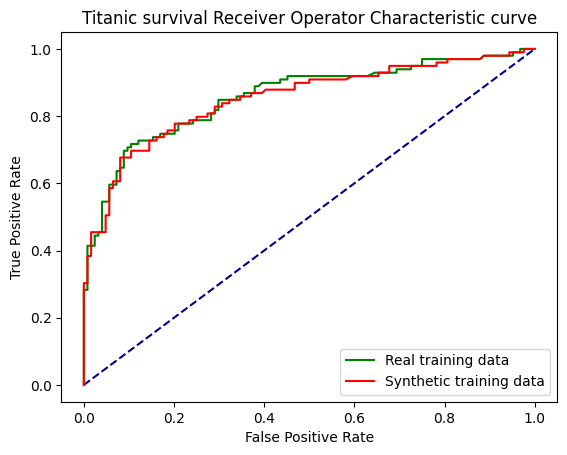

In [30]:
fig, ax = plt.subplots()

# Plot ROC
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax.plot(fpr,tpr, color='green', label = 'Real training data')
ax.plot(fpr_synth,tpr_synth, color='red', label = 'Synthetic training data')

ax.set_title('Titanic survival Receiver Operator Characteristic curve')

ax.legend()

fig.savefig('images/synthetic_roc.png')
fig.show()

## Conclusions

Here we have used the SMOTE method to create synthetic data to replace the real Titanic data. We have removed any data points that are identical to the original data, and have also removed 10% of synthetic data points that are closest to original data.  We found that SMOTE generated synthetic data that could train a logistic regression model for our problem with minimal loss of accuracy when compared with training with the original data.